In [1]:
import pandas as pd
import numpy as np
from my_pysyncon import Dataprep, Synth, AugSynth
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import empirical_covariance
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import the data

df_mo = pd.read_csv('../../../SharedData/total_state_data.csv')
df_yr = pd.read_csv('../../../SharedData/yearly_total_data.csv')

In [3]:
# this list is used to make certain columns later

abbreviations = [
    "AL", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA",
    "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
    "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
    "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC",
    "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"
]

In [4]:
# add a bunch of features (these will eventually get moved to combine_files.ipynb)

df_mo['co2_per_capita'] = df_mo['monthly_emissions'] / df_mo['monthly_population']
df_mo['gdp_per_capita'] = df_mo['gdp_rel_2017_interp'] / df_mo['monthly_population']
df_mo['eprod_per_capita'] = df_mo['monthly_energy_prod'] / df_mo['monthly_population']
df_mo['eflow_per_capita'] = df_mo['monthly_energy_flow'] / df_mo['monthly_population']
df_mo['euse_per_capita'] = df_mo['monthly_energy_use'] / df_mo['monthly_population']
#df_mo['num_plants_per_capita'] = df_mo['monthly_num_plants'] / df_mo['monthly_population']

# create column for simple moving avg of co2_per_capita; ma_window is the moving average window size (n=1 corresponds to usual monthly results)

df_mo['co2_per_capita_sma']= np.nan
ma_window = 12

for state in abbreviations:
    df_mo.loc[df_mo.state==state,'co2_per_capita_sma'] = df_mo.loc[df_mo.state==state,'co2_per_capita'].rolling(window=ma_window).mean()


df_yr['co2_per_capita'] = df_yr['yearly_emissions'] / df_yr['yearly_population']
df_yr['gdp_per_capita'] = df_yr['yearly_gdp_rel_2017'] / df_yr['yearly_population']
df_yr['eprod_per_capita'] = df_yr['yearly_energy_prod'] / df_yr['yearly_population']
df_yr['eflow_per_capita'] = df_yr['yearly_energy_flow'] / df_yr['yearly_population']
df_yr['euse_per_capita'] = df_yr['yearly_energy_use'] / df_yr['yearly_population']
#df_yr['num_plants_per_capita'] = df_yr['yearly_num_plants'] / df_yr['yearly_population']

In [ ]:
treatment_date = '2009-01-01'
preintervention_ma_start_date = str((pd.to_datetime('1991-05-01')+ pd.DateOffset(months=ma_window-1)).strftime('%Y-%m-%d'))

# these are the time values where CO2 per capita is fit
preintervention_time_range = df_mo.date[(df_mo.date >= '1990-06-01')&(df_mo.date<treatment_date)&(df_mo.state=='MI')]

# these are dates that Jared is testing to see if other time subsets give better fits


# these are the time values where our features are fit (subset of preintervention_time_range)
preintervention_feature_range = df_mo.date[(df_mo.date >= '1990-06-01') & (df_mo.date<treatment_date)&(df_mo.state=='MI')]
preintervention_gdp_range = df_mo.date[(df_mo.date >= '1997-12-01') & (df_mo.date<treatment_date)&(df_mo.state=='MI')]
preintervention_per_capita_range = df_mo.date[(df_mo.date >= '1990-06-01') & (df_mo.date<treatment_date)&(df_mo.state=='MI')]
preintervention_energy_range = df_mo.date[(df_mo.date >= '1990-12-01') & (df_mo.date<treatment_date)&(df_mo.state=='MI')]
preintervention_ma_range = df_mo.date[(df_mo.date >= preintervention_ma_start_date) & (df_mo.date<treatment_date)&(df_mo.state=='MI')]


# these are the dates used for our monthly_emissions graph
years = pd.date_range(start='1990-06-01', end='2019-12-01', freq='MS').strftime('%Y-%m-%d').tolist()

# these are the dates used for our monthly_emissions SMA graph
years_sma = pd.date_range(start=preintervention_ma_start_date, end='2019-12-01', freq='MS').strftime('%Y-%m-%d').tolist()

## PCA Calculation

In [6]:
# separate df_mo into two pieces
non_pca_cols = df_mo[(df_mo.date >= '1990-11')&(df_mo.date <='2019-12-01')][['state','date','co2_per_capita_sma','gdp_per_capita','monthly_num_plants']]
num_cols = df_mo[(df_mo.date>=preintervention_ma_start_date) & (df_mo.date<=treatment_date)].drop(columns=['state','date','co2_per_capita_sma'])
# drop outcomes for PCA; 
# drop weather data because too many missing values
# drop GDP and num_plants because only have data for 1997-
# drop yearly data because this is PCA for monthly model
# drop non-per-capita versions of per-capita data to reduce redundancy
# drop non-density versions of data to reduce redundancy
df_mo_pca = num_cols[[
       'yearly_renew_pct', 'yearly_fossil_pct','monthly_pop_density']]
print('number of features before PCA calculation is',len(df_mo_pca.columns))

# save the indices to be used later in pca_df
df_mo_pca_indices = df_mo_pca.index

# make covariance matrix to see how features are correlated
empirical_covariance(df_mo_pca)

number of features before PCA calculation is 3


array([[ 0.04313626, -0.03498554,  0.00227084],
       [-0.03498554,  0.06407747,  0.00082171],
       [ 0.00227084,  0.00082171,  0.00159197]])

In [7]:
# We'll use PCA to make the covariates independent (which I think is an underlying assumption of a diagonal V)
# Standardize the covariates
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_mo_pca)


# make covariance matrix to see how features are correlated
print('Covariance matrix of original (scaled) features:\n',empirical_covariance(df_mo_pca),'\n')


# Apply PCA
n_components = len(df_mo_pca.columns)
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)


# Add the state and date back
pca_col_names = ['PCA'+str(i) for i in range(1,n_components+1)]
pca_df = pd.DataFrame(X_pca, columns=pca_col_names)
cov_mat = empirical_covariance(pca_df)
cov_mat[np.abs(cov_mat)<10**(-5)]=0
np.set_printoptions(suppress=True)
print('Percent of total variance from each component:\n', np.diag(cov_mat)/np.trace(cov_mat)*100,'\n')
print('Each component as a linear combination of orig. features:\n', pca.components_)

Covariance matrix of original (scaled) features:
 [[ 0.04313626 -0.03498554  0.00227084]
 [-0.03498554  0.06407747  0.00082171]
 [ 0.00227084  0.00082171  0.00159197]] 

Percent of total variance from each component:
 [56.47025995 35.23064484  8.29909521] 

Each component as a linear combination of orig. features:
 [[ 0.7183478  -0.66457715  0.20570284]
 [ 0.08101935  0.37359024  0.92404881]
 [ 0.69095029  0.64712251 -0.32221133]]


This suggests that we only need 4 components (since the 5th component composes 0.026% of total variance). So let's redo the PCA with n_components = 4.

In [8]:
# We'll use PCA to make the covariates independent (which I think is an underlying assumption of a diagonal V)
# Standardize the covariates
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_mo_pca)

# Apply PCA
n_components = n_components-1
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# Add the state and date back
pca_col_names = ['PCA'+str(i) for i in range(1,n_components+1)]
pca_df = pd.DataFrame(X_pca, columns=pca_col_names)
pca_df.index = df_mo_pca_indices
cov_mat = empirical_covariance(pca_df)
cov_mat[np.abs(cov_mat)<10**(-5)]=0
np.set_printoptions(suppress=True)
print('Percent of total variance from each component:', np.diag(cov_mat)/np.trace(cov_mat)*100)


merged_pca_df = pca_df.merge(non_pca_cols, left_index=True, right_index=True, how='right')

Percent of total variance from each component: [61.58091905 38.41908095]


We prepare the study data using a `Dataprep` object that describes all the details needed to define the synthetic control study. This works similarly to the `dataprep` method in the `R` package `synth`.

(For an explanation of each of the `Dataprep` arguments, see the package [documentation](https://sdfordham.github.io/pysyncon/dataprep.html#pysyncon.Dataprep)).

In [9]:
# we leave off RGGI states;
# states with no CO2 data (AK, HI);
# states with some type of emissions program (CA, WA, OR, MN);
# and states with very high CO2 per capita (WY, ND, WV, LA)

rggi_states = ['CT', 'DE', 'ME', 'MD', 'MA', 'NH', 'NJ', 'NY', 'RI', 'VT', 'VA']

non_rggi_controls_identifier= [
    "AL", 
    #"AK", 
    "AZ", "AR", 
    #"CA", 
    "CO", 
    #"CT", 
    #"DE", 
    "FL", 
    "GA",
    #"HI", 
    "ID", "IL", "IN", "IA", "KS", "KY", 
    #"LA", 
    #"ME", 
    #"MD",
    #"MA", 
    "MI", 
    #"MN", 
    "MS", "MO", "MT", "NE", "NV", 
    #"NH", 
    #"NJ",
    "NM", "NC", 
    #"ND", 
    #"NY",
    "OH", "OK", 
    #"OR", 
    "PA", 
    #"RI", 
    "SC", "SD", "TN", 
    "TX", 
    "UT", 
    #"VT", 
    #"VA", 
    #"WA", 
    #"WV", 
    "WI", 
    #"WY"
    ]

In [10]:
# we create a synthetic control Delaware as applied to monthly_emissions data

dataprep_mo = Dataprep(
    foo=df_mo,
    predictors=['co2_per_capita'],
    predictors_op="mean",
    time_predictors_prior=preintervention_feature_range,
    special_predictors=[
        ('monthly_num_plants', preintervention_energy_range, "std"),
        ('eprod_per_capita', preintervention_energy_range, "mean"),
        ('euse_per_capita', preintervention_energy_range, "mean"),
        ('gdp_per_capita', preintervention_gdp_range, "mean"),
        ('monthly_pop_density', preintervention_per_capita_range, "mean"),
        ('yearly_renew_pct', preintervention_energy_range, "mean"),
        ('yearly_fossil_pct', preintervention_energy_range, "mean")
        ],
    dependent="co2_per_capita",
    unit_variable="state",
    time_variable="date",
    treatment_identifier="DE",
    controls_identifier= non_rggi_controls_identifier,
    time_optimize_ssr=preintervention_time_range
    )

In [11]:
# we create a synthetic control Delaware as applied to monthly_emissions SMA data

dataprep_mo_ma = Dataprep(
    foo=df_mo,
    predictors=[],
    predictors_op="mean",
    time_predictors_prior=preintervention_ma_range,
    special_predictors=[
        ('monthly_num_plants', preintervention_feature_range, "max"),
        ('eprod_per_capita', preintervention_energy_range, "mean"),
        ('euse_per_capita', preintervention_energy_range, "mean"),
        ('gdp_per_capita', preintervention_gdp_range, "mean"),
        ('monthly_pop_density', preintervention_per_capita_range, "mean"),
        ('yearly_renew_pct', preintervention_energy_range, "mean"),
        ('yearly_fossil_pct', preintervention_energy_range, "mean")
        ],
    dependent="co2_per_capita_sma",
    unit_variable="state",
    time_variable="date",
    treatment_identifier="DE",
    controls_identifier= non_rggi_controls_identifier,
    time_optimize_ssr=preintervention_ma_range
    )

In [12]:
# we create a synthetic control Delaware as applied to monthly_emissions SMA PCA data

dataprep_mo_ma_pca = Dataprep(
    foo=merged_pca_df,
    predictors=pca_col_names+[],
    predictors_op="mean",
    time_predictors_prior=preintervention_feature_range,
    special_predictors=[
        ('monthly_num_plants', preintervention_feature_range, "max"),
        ('gdp_per_capita', preintervention_gdp_range, "mean")
        ],
    dependent="co2_per_capita_sma",
    unit_variable="state",
    time_variable="date",
    treatment_identifier="NY",
    controls_identifier= non_rggi_controls_identifier,
    time_optimize_ssr=preintervention_ma_range
    )

In [13]:
# we create a synthetic control Delaware as applied to yearly data

dataprep_yr = Dataprep(
    foo=df_yr,
    predictors=[],
    predictors_op="mean",
    time_predictors_prior=range(1997,2009),#range(1997,2009),
    special_predictors=[
        ('yearly_num_plants', range(1997,2009), "max"),
        ('eprod_per_capita', range(1990,2009), "mean"),
        ('eflow_per_capita', range(1990,2009), "mean"),
        ('gdp_per_capita', range(1997,2009), "mean"),
        ('yearly_pop_density', range(1990,2009), "mean"),
        ('yearly_renew_pct', range(1990,2009), "mean"),
        ('yearly_fossil_pct', range(1990,2009), "mean")
        ],
    dependent="co2_per_capita",
    unit_variable="state",
    time_variable="year",
    treatment_identifier="DE",
    controls_identifier= non_rggi_controls_identifier,
    time_optimize_ssr=range(1990,2009)
)

#print(dataprep_yr)


We supply the `Dataprep` object to a `Synth` object. The optimization scheme we could use is [BFGS](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-bfgs.html) and the starting point we could use for the optimisation is `ols` i.e. the initial weights are obtained by fitting an ordinary-least-squares estimate. (Unlike the `R` package `synth` which performs four different runs under the hood (two different starting points and two different optimisation schemes), in this package only one optimisation is run per `fit`).

*Nota bene that the weights obtained by the synthetic control method are often highly sensitive to the chosen optimisation scheme and starting point.*

In [14]:
# monthly_emissions version
# loss_V represents the MSPE (mean squared prediction error) PRIOR to treatment
# loss_V incorporates matrix of weights W and CO2 outcomes
# loss_W incorporates covariates (predictors) and constraint of weights summing to 1
# best values of loss_W are close to 0 (but loss_V is more consequential for us!)

synth_mo = Synth()
synth_mo.fit(dataprep=dataprep_mo, optim_initial='equal')
#print(synth_mo.weights(threshold=.01))
#print(synth_mo.loss_V)
#print(synth_mo.loss_W)

In [15]:
# monthly_emissions SMA version

synth_mo_ma = Synth()
synth_mo_ma.fit(dataprep=dataprep_mo_ma, optim_initial='equal')
#print(synth_mo_ma.weights(threshold=.01))
#print(synth_mo_ma.loss_V)
#print(synth_mo_ma.loss_W)

# how different is co2_per_capita_sma different than co2_per_capita?
sma_mse = mean_squared_error(df_mo[(df_mo.date>=preintervention_ma_start_date) & (df_mo.date<=treatment_date)]['co2_per_capita'], df_mo[(df_mo.date>=preintervention_ma_start_date) & (df_mo.date<=treatment_date)].co2_per_capita_sma)
#print('The pre-treatment fit loss is:', synth_mo_ma.loss_V, 'and the rolling average loss is:',sma_mse)


In [16]:
print('errors of interest are\nmonthly:',synth_mo.loss_V,'\nmonthly_sma:',synth_mo_ma.loss_V)

errors of interest are
monthly: 0.03496079962607773 
monthly_sma: 0.011611132431936446


In [17]:
# monthly_emissions SMA PCA version

synth_mo_ma_pca = Synth()
synth_mo_ma_pca.fit(dataprep=dataprep_mo_ma_pca,optim_method='Powell')
print(synth_mo_ma_pca.weights(threshold=.01))
print(synth_mo_ma_pca.loss_V)
#print(synth_mo_ma.loss_W)

# how different is co2_per_capita_sma different than co2_per_capita?
#sma_mse = mean_squared_error(df_mo[(df_mo.date>=preintervention_ma_start_date) & (df_mo.date<=treatment_date)]['co2_per_capita'], df_mo[(df_mo.date>=preintervention_ma_start_date) & (df_mo.date<=treatment_date)].co2_per_capita_sma)
#print('The pre-treatment fit loss is:', synth_mo_ma.loss_V, 'and the rolling average loss is:',sma_mse)


ID    0.128
IL    0.872
Name: weights, dtype: float64
0.09871083830384811


In [18]:
# yearly version

synth_yr= Synth()
synth_yr.fit(dataprep=dataprep_yr, optim_initial='equal')
print(synth_yr.weights(threshold=.01))
print(synth_yr.loss_V)
#print(synth_mo.loss_W)

IL    0.46
NV    0.54
Name: weights, dtype: float64
1.6545743312393828


In [19]:
# these lists are used for treatment_time in graphs below

treatment_dates = []
for year in years:
    if year.startswith('2009'):
        treatment_dates.append(year)

treatment_dates_ma = []
for year in years_sma:
    if year.startswith('2009'):
        treatment_dates_ma.append(year)

355
[0, 71, 142, 213, 284]


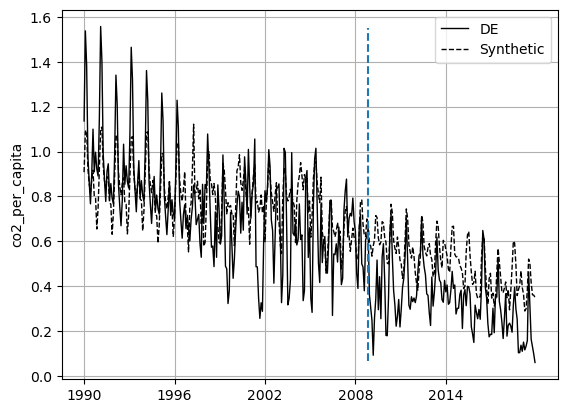

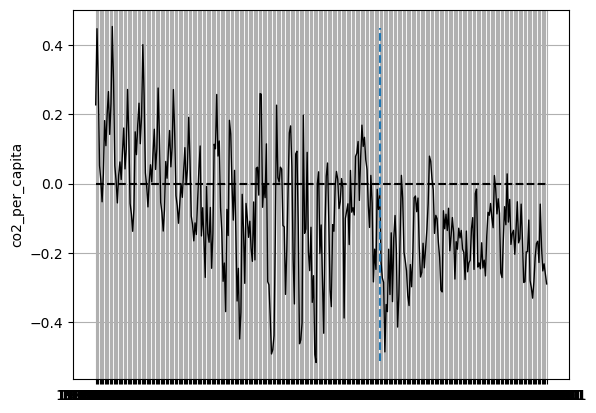

In [20]:
# Monthly_emissions synthetic control plot

synth_mo.path_plot(time_period=years, treatment_time=treatment_dates[0])
synth_mo.gaps_plot(time_period=years, treatment_time=treatment_dates[0])

333
[0, 66, 132, 198, 264, 330]


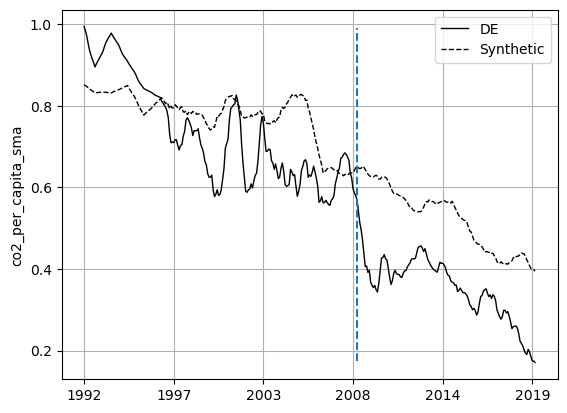

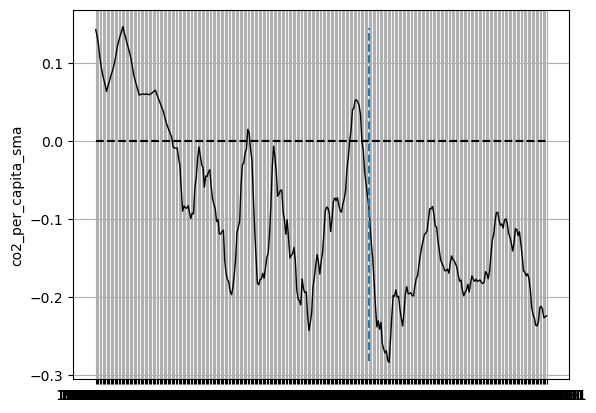

In [21]:
# Monthly_emissions SMA synthetic control plot

synth_mo_ma.path_plot(time_period=years_sma, treatment_time=treatment_dates_ma[0])
synth_mo_ma.gaps_plot(time_period=years_sma, treatment_time=treatment_dates_ma[0])

333
[0, 66, 132, 198, 264, 330]


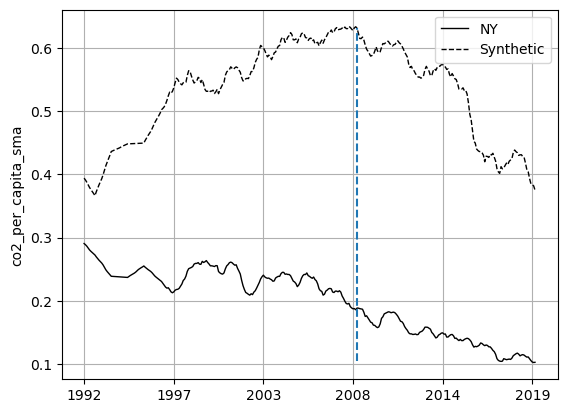

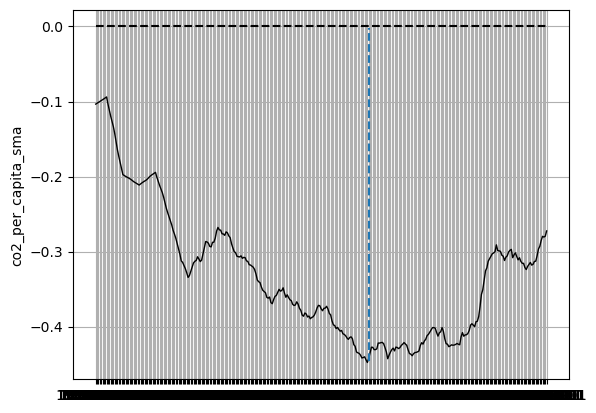

In [22]:
synth_mo_ma_pca.path_plot(time_period=years_sma, treatment_time=treatment_dates_ma[0])
synth_mo_ma_pca.gaps_plot(time_period=years_sma, treatment_time=treatment_dates_ma[0])

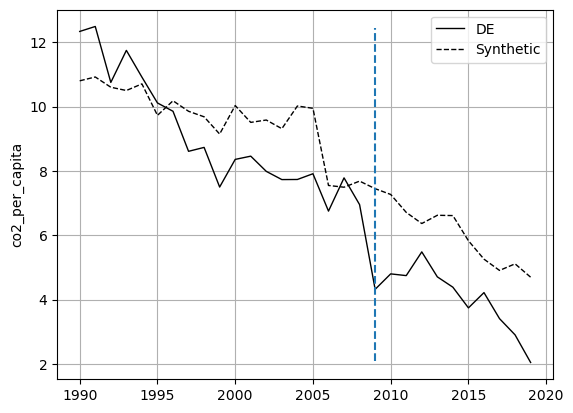

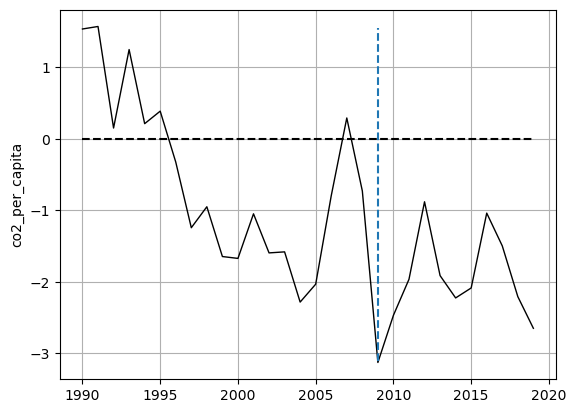

In [23]:
# Yearly synthetic control plot

synth_yr.path_plot_orig(time_period=range(1990,2020), treatment_time=2009)
synth_yr.gaps_plot(time_period=range(1990,2020), treatment_time=2009)

The summary function give more information on the predictor values. The first column shows the value of the $V$ matrix for each predictor, the column 'treated' shows the mean value of each predictor for the treated unit over the time period `time_predictors_prior`, the column 'synthetic' shows the mean value of each predictor for the synthetic control over the time period `time_predictors_prior` and finally the column 'sample mean' shows the sample mean of that predictor for all control units over the time period `time_predictors_prior` i.e. this is the same as the synthetic control with all weights equal.

In [24]:
df_mo[df_mo.state=='DE'].monthly_num_plants.max()

np.float64(12.0)

In [25]:
synth_mo.summary()

,V,treated,synthetic,sample mean
co2_per_capita,0.131,0.753,0.790,0.981
special.1.monthly_num_plants,0.094,2.074,7.324,5.014
special.2.eprod_per_capita,0.109,0.000,0.007,0.023
special.3.euse_per_capita,0.066,0.030,0.025,0.030
special.4.gdp_per_capita,0.162,0.006,0.005,0.004
special.5.monthly_pop_density,0.249,0.003,0.033,0.028
special.6.yearly_renew_pct,0.186,0.000,0.062,0.096
special.7.yearly_fossil_pct,0.003,0.963,0.691,0.724


In [26]:
synth_mo_ma.summary()

,V,treated,synthetic,sample mean
special.1.monthly_num_plants,0.072,12.000,41.459,33.690
special.2.eprod_per_capita,0.100,0.000,0.008,0.023
special.3.euse_per_capita,0.067,0.030,0.025,0.030
special.4.gdp_per_capita,0.226,0.006,0.005,0.004
special.5.monthly_pop_density,0.257,0.003,0.031,0.028
special.6.yearly_renew_pct,0.207,0.000,0.059,0.096
special.7.yearly_fossil_pct,0.070,0.963,0.682,0.724


In [27]:
synth_mo_ma_pca.summary()

,V,treated,synthetic,sample mean
PCA1,0.999,0.519,0.519,-0.187
PCA2,0.000,-0.726,-0.667,0.095
special.1.monthly_num_plants,0.000,92.000,58.938,33.690
special.2.gdp_per_capita,0.000,0.005,0.004,0.004


In [28]:
synth_yr.summary()

,V,treated,synthetic,sample mean
special.1.yearly_num_plants,0.114,8.000,29.113,28.207
special.2.eprod_per_capita,0.156,0.002,0.083,0.279
special.3.eflow_per_capita,0.115,-0.359,-0.224,-0.080
special.4.gdp_per_capita,0.127,0.078,0.057,0.046
special.5.yearly_pop_density,0.236,0.003,0.035,0.029
special.6.yearly_renew_pct,0.194,0.000,0.066,0.096
special.7.yearly_fossil_pct,0.059,0.964,0.703,0.723


## RGGI State Synthetic Control Comparisons

First, we compare the RGGI synthetic controls at the monthly level.

355
[0, 71, 142, 213, 284]


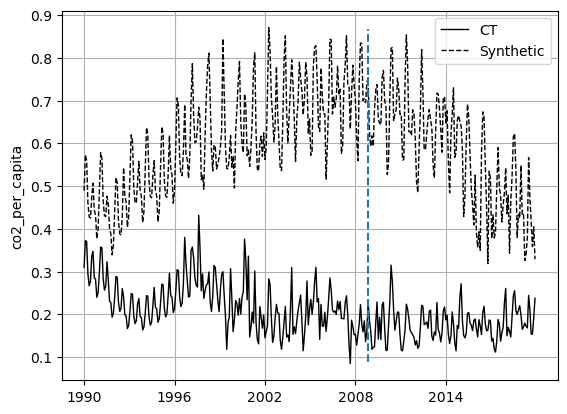

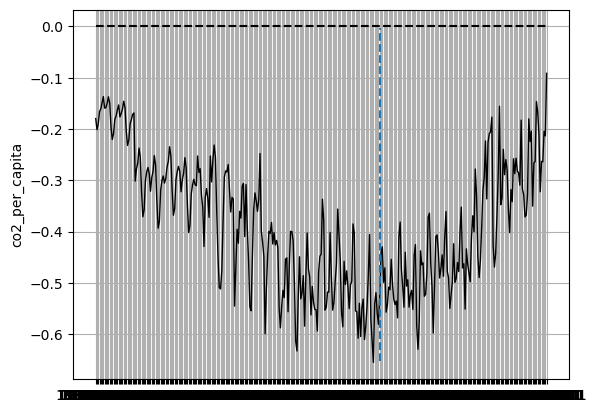

333
[0, 66, 132, 198, 264, 330]


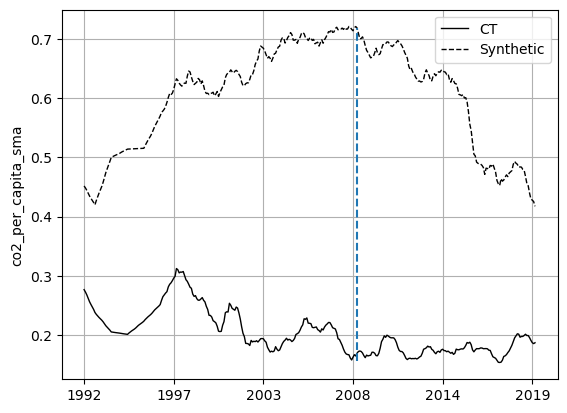

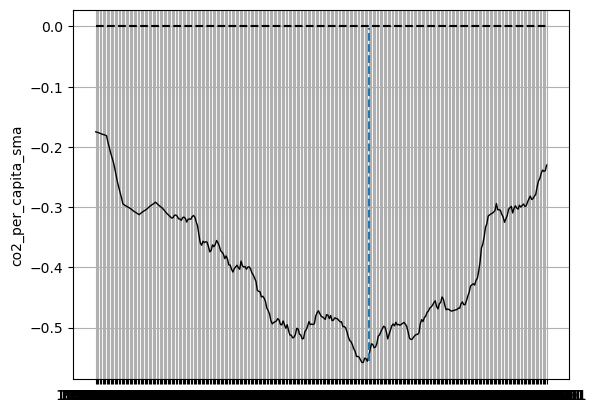

State: CT 

monthly_emissions version: 

IL    1.0
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.008   15.229     41.028       23.450
special.1.eprod_per_capita     0.129    0.005      0.013        0.023
special.2.eflow_per_capita     0.164   -0.015     -0.013       -0.007
special.3.gdp_per_capita       0.156    0.006      0.005        0.004
special.4.monthly_pop_density  0.195    0.002      0.005        0.028
special.5.yearly_renew_pct     0.135    0.016      0.002        0.096
special.6.yearly_fossil_pct    0.214    0.461      0.500        0.724
monthly_emissions SMA version: 

IL    1.0
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.012   15.229     41.028       23.450
special.1.eprod_per_capita     0.128    0.005      0.013        0.023
special.2.eflow_per_capita     0.163   -0.015     -0.013       -0.007
sp

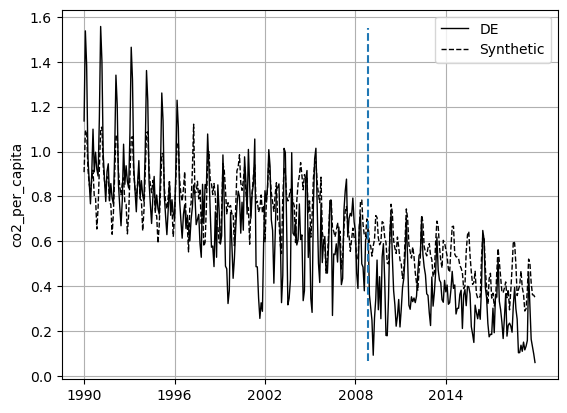

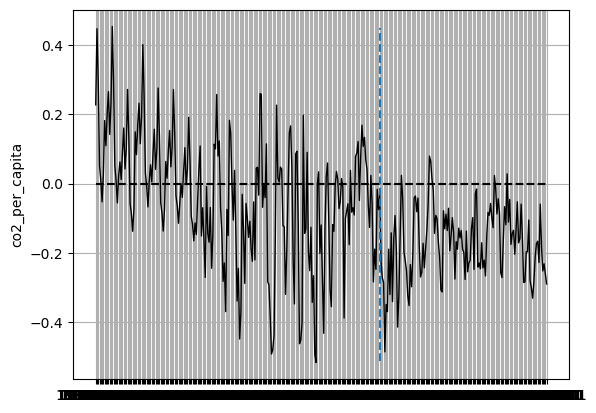

333
[0, 66, 132, 198, 264, 330]


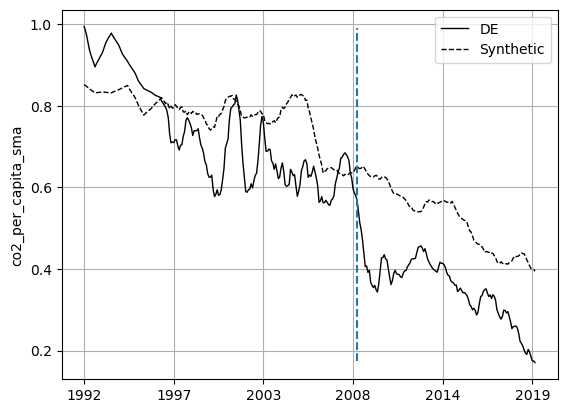

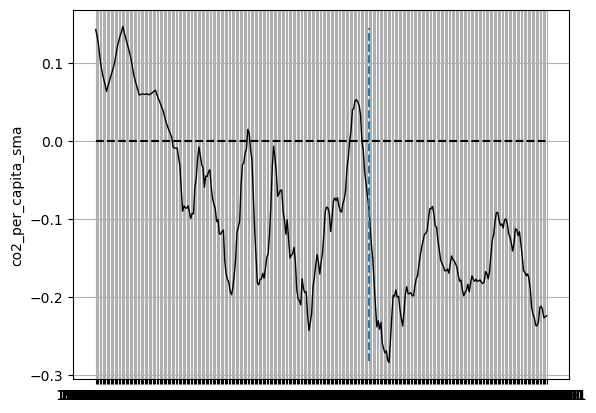

State: DE 

monthly_emissions version: 

IL    0.495
NV    0.505
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.095    7.840     25.116       23.450
special.1.eprod_per_capita     0.183    0.000      0.007        0.023
special.2.eflow_per_capita     0.087   -0.030     -0.018       -0.007
special.3.gdp_per_capita       0.142    0.006      0.005        0.004
special.4.monthly_pop_density  0.225    0.003      0.033        0.028
special.5.yearly_renew_pct     0.202    0.000      0.062        0.096
special.6.yearly_fossil_pct    0.066    0.963      0.691        0.724
monthly_emissions SMA version: 

IL    0.518
NV    0.482
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.110    7.840     25.854       23.450
special.1.eprod_per_capita     0.179    0.000      0.008        0.023
special.2.eflow_per_capita     0.093   -0.03

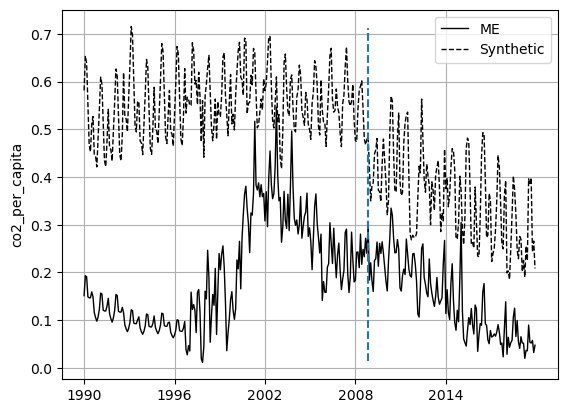

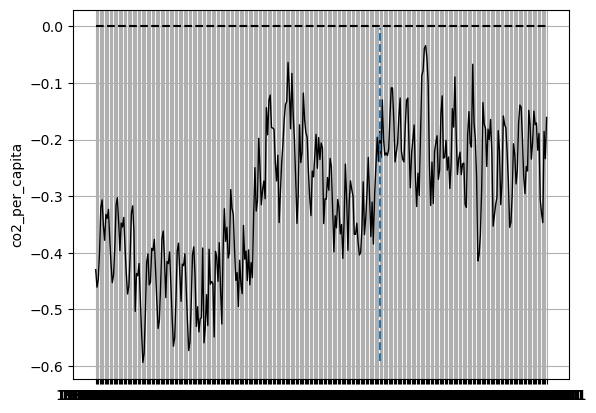

333
[0, 66, 132, 198, 264, 330]


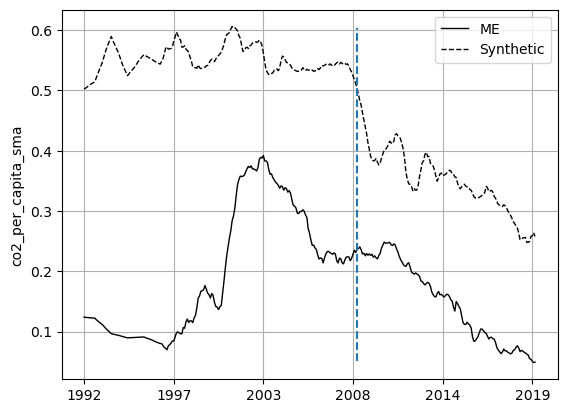

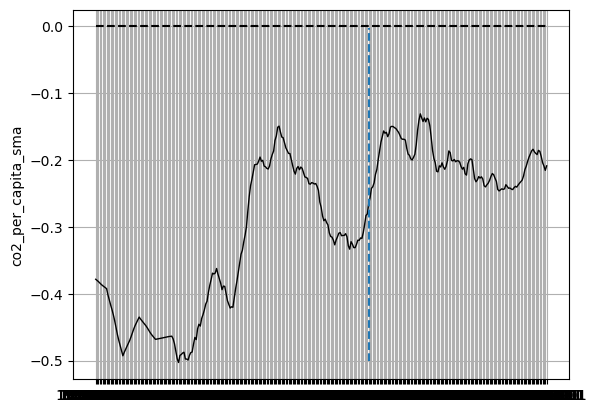

State: ME 

monthly_emissions version: 

ID    0.381
NM    0.027
SC    0.144
TN    0.448
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.150    4.479      8.388       23.450
special.1.eprod_per_capita     0.254    0.010      0.009        0.023
special.2.eflow_per_capita     0.116   -0.018     -0.020       -0.007
special.3.gdp_per_capita       0.001    0.004      0.003        0.004
special.4.monthly_pop_density  0.194    0.028      0.032        0.028
special.5.yearly_renew_pct     0.000    0.240      0.384        0.096
special.6.yearly_fossil_pct    0.285    0.396      0.403        0.724
monthly_emissions SMA version: 

ID    0.399
NM    0.026
SC    0.049
TN    0.517
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.193    4.479      7.665       23.450
special.1.eprod_per_capita     0.134    0.010      0.009        0.

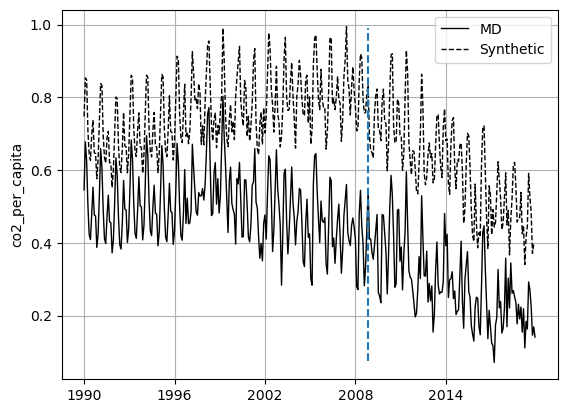

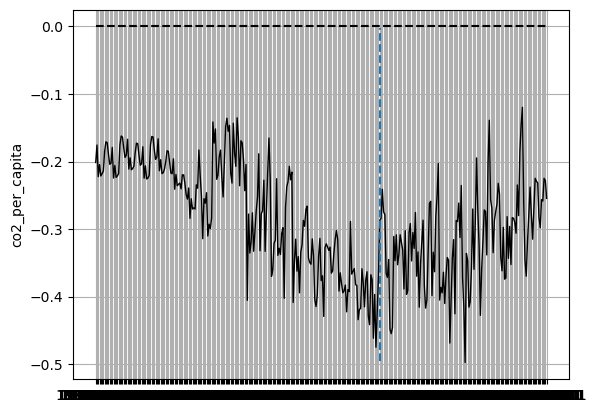

333
[0, 66, 132, 198, 264, 330]


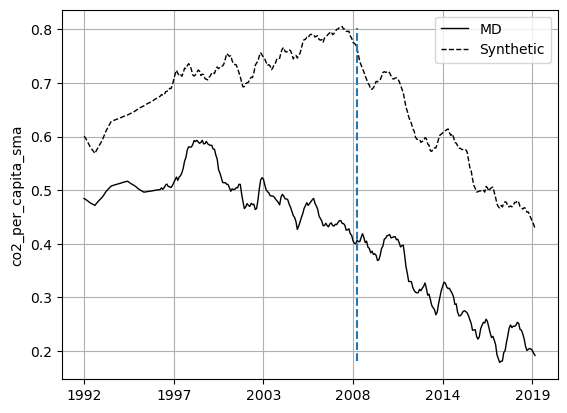

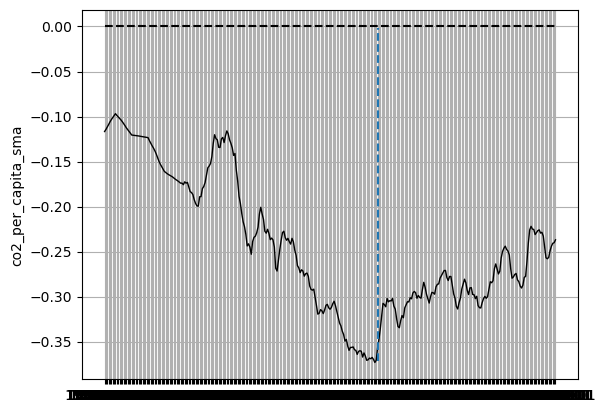

State: MD 

monthly_emissions version: 

GA    0.165
IL    0.508
NV    0.042
OH    0.286
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.000   13.000     34.444       23.450
special.1.eprod_per_capita     0.137    0.004      0.010        0.023
special.2.eflow_per_capita     0.160   -0.018     -0.018       -0.007
special.3.gdp_per_capita       0.195    0.004      0.004        0.004
special.4.monthly_pop_density  0.202    0.002      0.007        0.028
special.5.yearly_renew_pct     0.172    0.038      0.012        0.096
special.6.yearly_fossil_pct    0.133    0.670      0.656        0.724
monthly_emissions SMA version: 

GA    0.479
IL    0.521
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.000   13.000     31.756       23.450
special.1.eprod_per_capita     0.144    0.004      0.010        0.023
special.2.eflow_per_

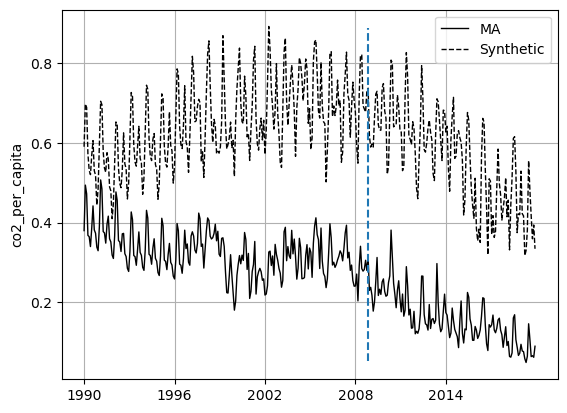

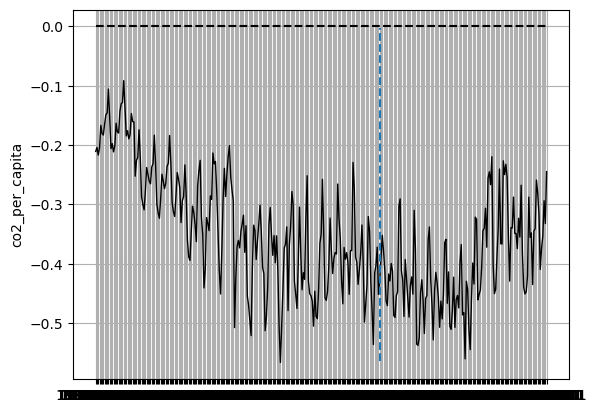

333
[0, 66, 132, 198, 264, 330]


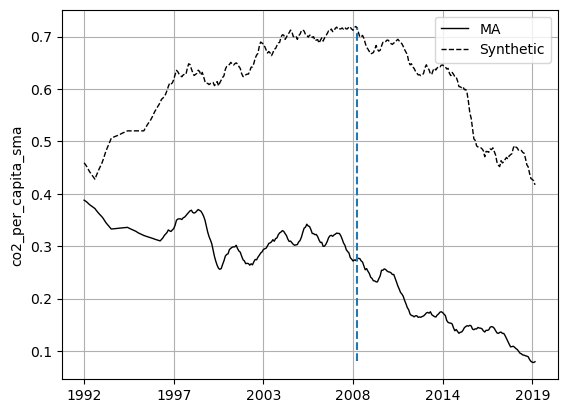

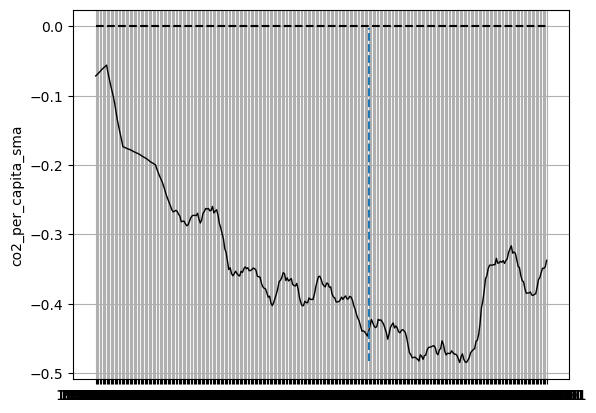

State: MA 

monthly_emissions version: 

IL    0.878
NV    0.122
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.102   26.167     37.183       23.450
special.1.eprod_per_capita     0.128    0.001      0.012        0.023
special.2.eflow_per_capita     0.357   -0.018     -0.014       -0.007
special.3.gdp_per_capita       0.103    0.005      0.005        0.004
special.4.monthly_pop_density  0.310    0.002      0.011        0.028
special.5.yearly_renew_pct     0.001    0.024      0.016        0.096
special.6.yearly_fossil_pct    0.000    0.823      0.546        0.724
monthly_emissions SMA version: 

IL    0.991
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.000   26.167     40.748       23.450
special.1.eprod_per_capita     0.179    0.001      0.013        0.023
special.2.eflow_per_capita     0.274   -0.018     -0.013

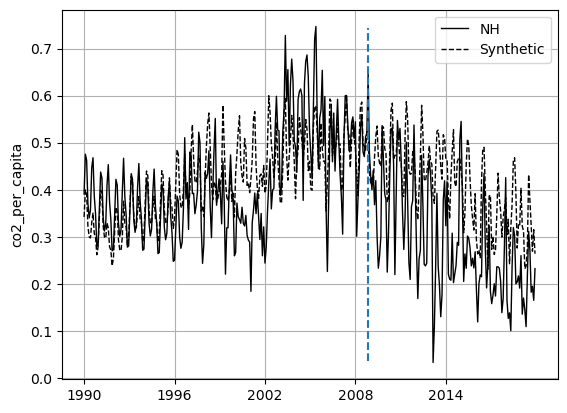

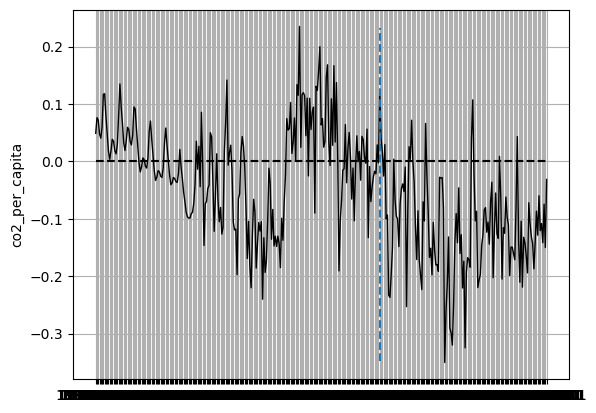

333
[0, 66, 132, 198, 264, 330]


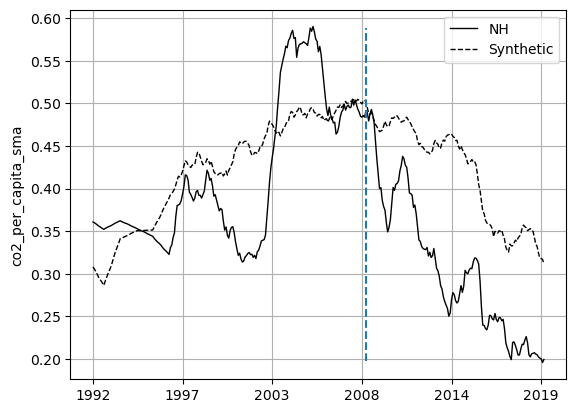

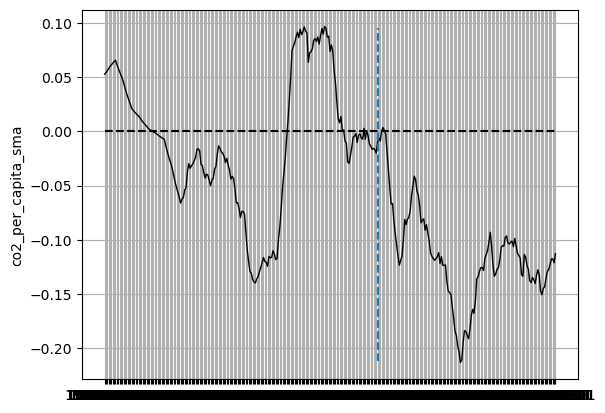

State: NH 

monthly_emissions version: 

ID    0.328
IL    0.661
NM    0.011
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.000    4.486     27.915       23.450
special.1.eprod_per_capita     0.019    0.008      0.012        0.023
special.2.eflow_per_capita     0.143   -0.011     -0.015       -0.007
special.3.gdp_per_capita       0.011    0.004      0.004        0.004
special.4.monthly_pop_density  0.025    0.008      0.026        0.028
special.5.yearly_renew_pct     0.001    0.084      0.289        0.096
special.6.yearly_fossil_pct    0.800    0.359      0.364        0.724
monthly_emissions SMA version: 

ID    0.318
IL    0.682
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.007    4.486     28.641       23.450
special.1.eprod_per_capita     0.080    0.008      0.011        0.023
special.2.eflow_per_capita     0

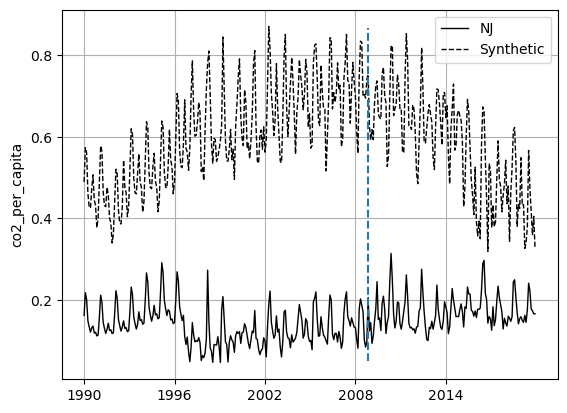

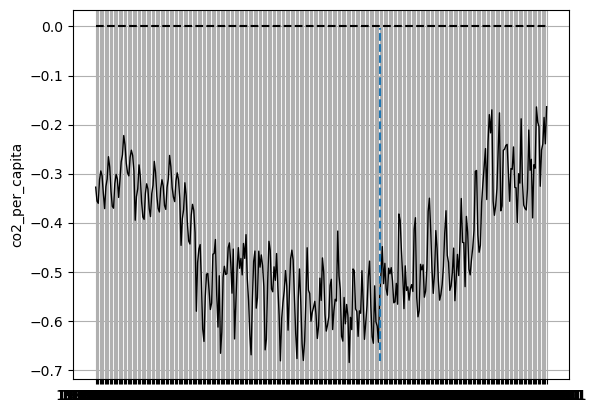

333
[0, 66, 132, 198, 264, 330]


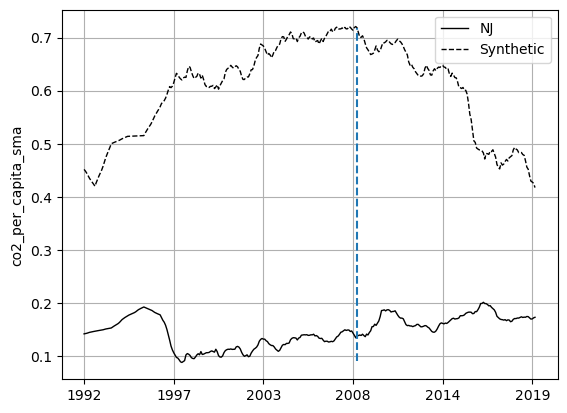

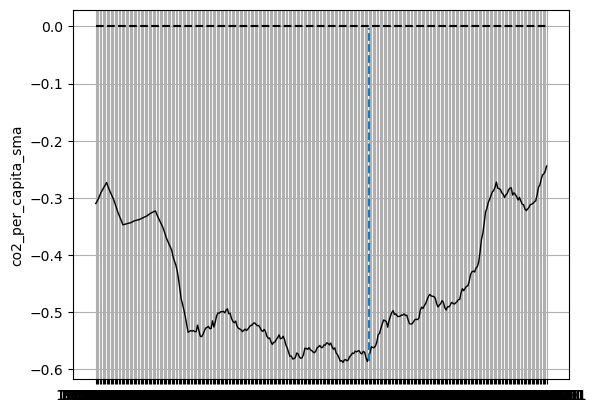

State: NJ 

monthly_emissions version: 

IL    1.0
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.004   31.917     41.028       23.450
special.1.eprod_per_capita     0.113    0.003      0.013        0.023
special.2.eflow_per_capita     0.133   -0.022     -0.013       -0.007
special.3.gdp_per_capita       0.079    0.005      0.005        0.004
special.4.monthly_pop_density  0.263    0.001      0.005        0.028
special.5.yearly_renew_pct     0.185    0.000      0.002        0.096
special.6.yearly_fossil_pct    0.224    0.496      0.500        0.724
monthly_emissions SMA version: 

IL    1.0
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.006   31.917     41.028       23.450
special.1.eprod_per_capita     0.110    0.003      0.013        0.023
special.2.eflow_per_capita     0.131   -0.022     -0.013       -0.007
sp

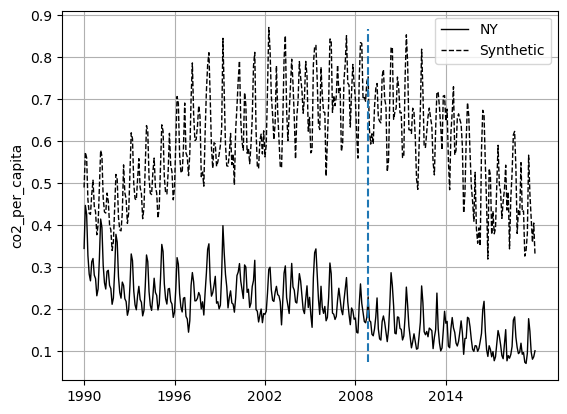

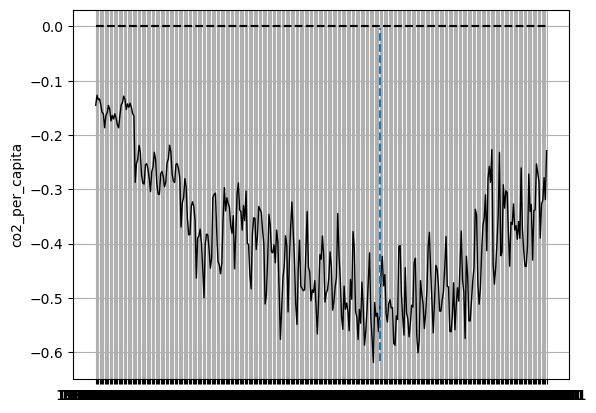

333
[0, 66, 132, 198, 264, 330]


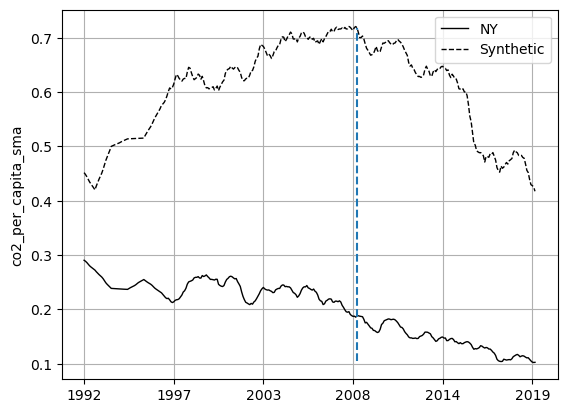

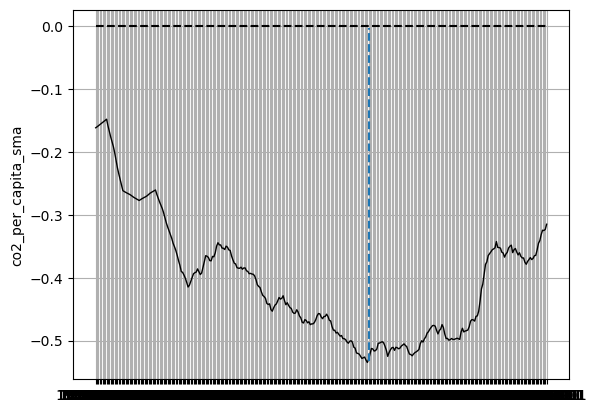

State: NY 

monthly_emissions version: 

IL    1.0
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.088   69.424     41.028       23.450
special.1.eprod_per_capita     0.173    0.003      0.013        0.023
special.2.eflow_per_capita     0.130   -0.014     -0.013       -0.007
special.3.gdp_per_capita       0.197    0.005      0.005        0.004
special.4.monthly_pop_density  0.163    0.003      0.005        0.028
special.5.yearly_renew_pct     0.119    0.195      0.002        0.096
special.6.yearly_fossil_pct    0.131    0.540      0.500        0.724
monthly_emissions SMA version: 

IL    1.0
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.089   69.424     41.028       23.450
special.1.eprod_per_capita     0.174    0.003      0.013        0.023
special.2.eflow_per_capita     0.127   -0.014     -0.013       -0.007
sp

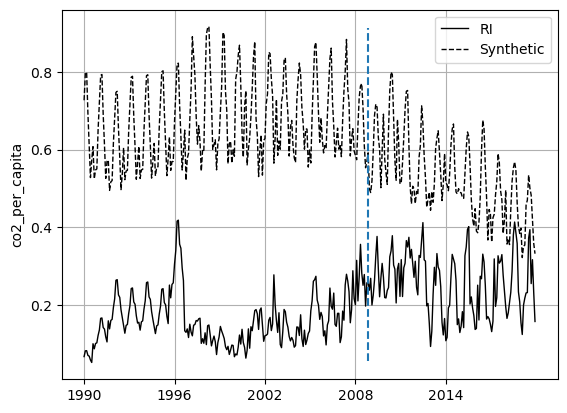

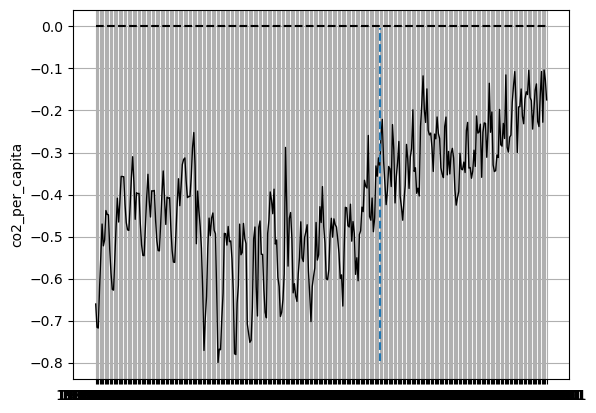

333
[0, 66, 132, 198, 264, 330]


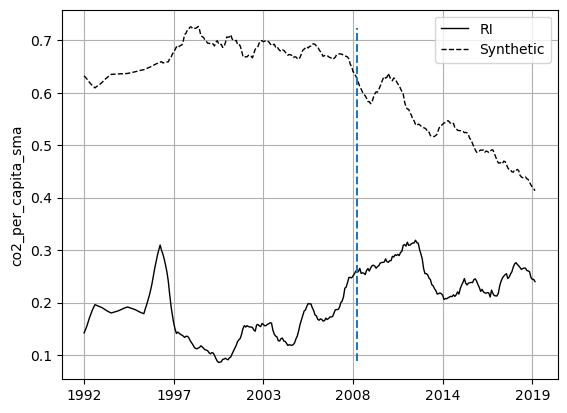

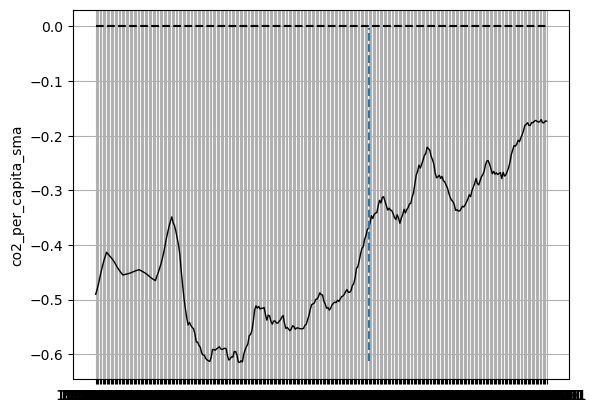

State: RI 

monthly_emissions version: 

FL    0.609
GA    0.199
IL    0.192
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.000    4.542     44.696       23.450
special.1.eprod_per_capita     0.288    0.000      0.005        0.023
special.2.eflow_per_capita     0.180   -0.017     -0.018       -0.007
special.3.gdp_per_capita       0.103    0.004      0.004        0.004
special.4.monthly_pop_density  0.256    0.001      0.005        0.028
special.5.yearly_renew_pct     0.173    0.001      0.007        0.096
special.6.yearly_fossil_pct    0.000    0.977      0.719        0.724
monthly_emissions SMA version: 

FL    0.704
GA    0.179
IL    0.118
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.000    4.542     46.252       23.450
special.1.eprod_per_capita     0.386    0.000      0.005        0.023
special.2.eflow_per_

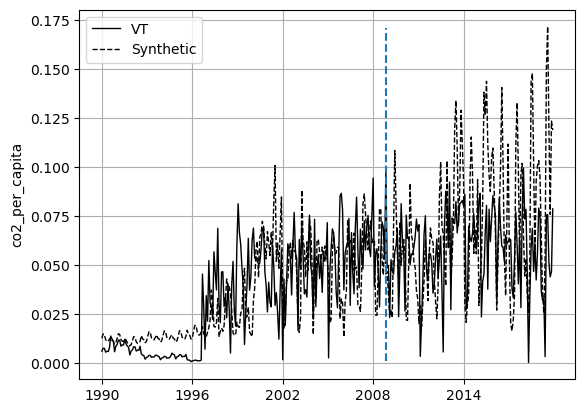

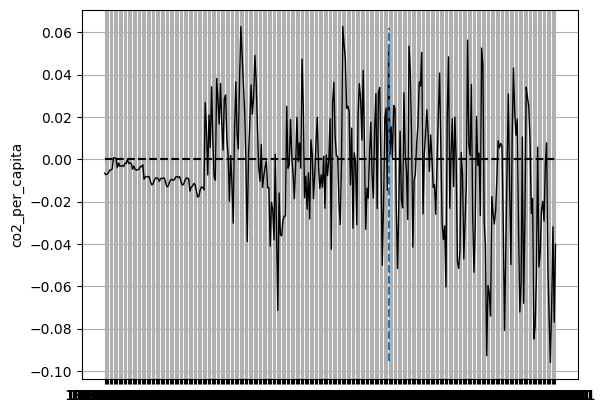

333
[0, 66, 132, 198, 264, 330]


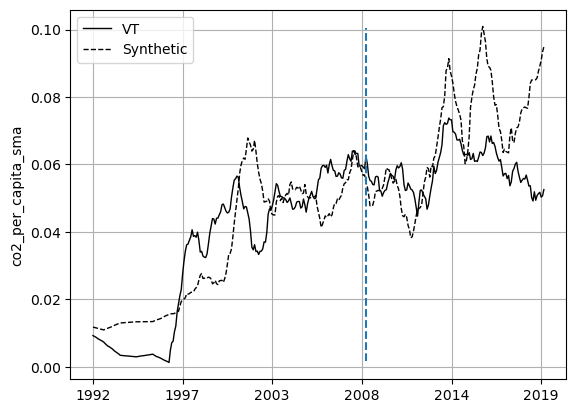

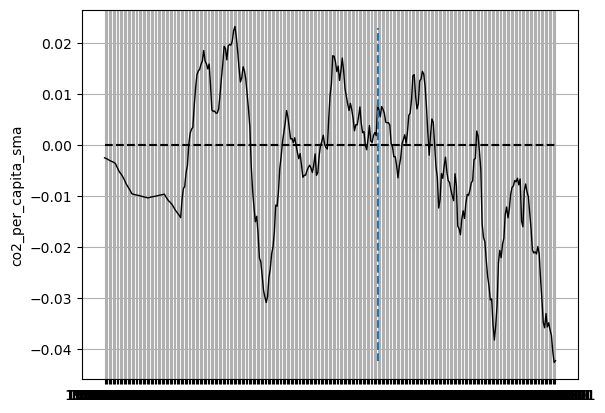

State: VT 

monthly_emissions version: 

ID    0.974
IL    0.026
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.154    1.000      3.098       23.450
special.1.eprod_per_capita     0.052    0.008      0.004        0.023
special.2.eflow_per_capita     0.177   -0.012     -0.023       -0.007
special.3.gdp_per_capita       0.032    0.004      0.003        0.004
special.4.monthly_pop_density  0.073    0.016      0.065        0.028
special.5.yearly_renew_pct     0.000    0.199      0.853        0.096
special.6.yearly_fossil_pct    0.512    0.006      0.082        0.724
monthly_emissions SMA version: 

ID    0.974
IL    0.026
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.154    1.000      3.107       23.450
special.1.eprod_per_capita     0.052    0.008      0.004        0.023
special.2.eflow_per_capita     0.177   -0.01

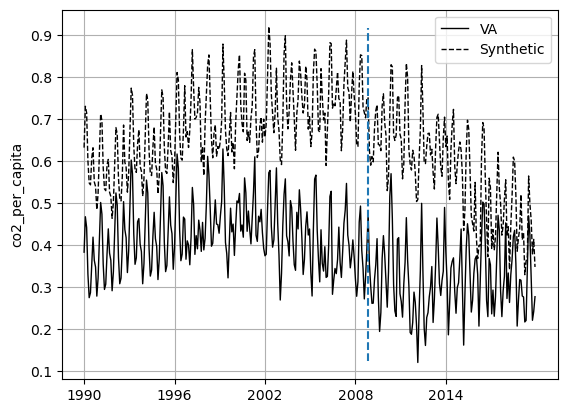

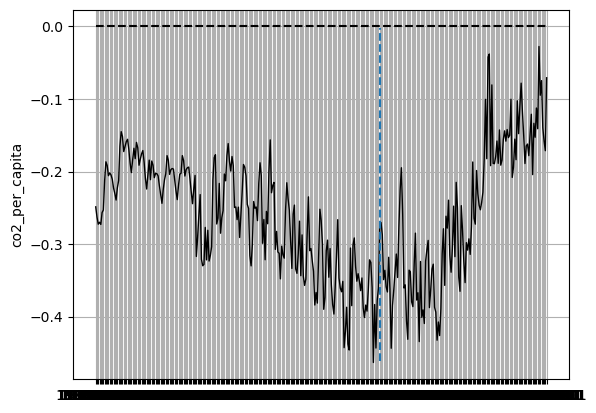

333
[0, 66, 132, 198, 264, 330]


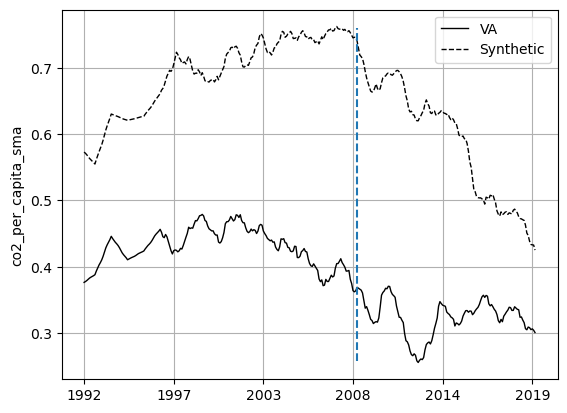

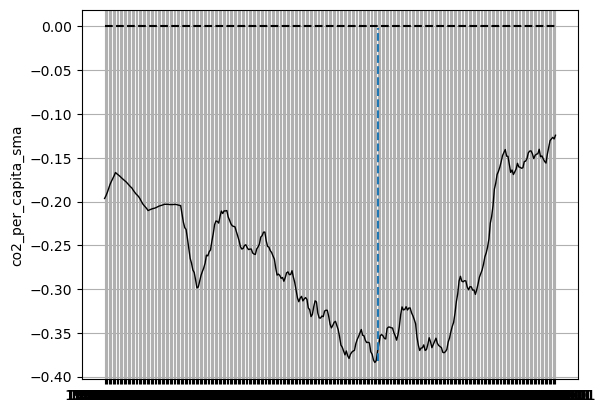

State: VA 

monthly_emissions version: 

CO    0.143
IL    0.685
TN    0.167
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.023   20.986     32.634       23.450
special.1.eprod_per_capita     0.163    0.016      0.015        0.023
special.2.eflow_per_capita     0.147   -0.011     -0.011       -0.007
special.3.gdp_per_capita       0.167    0.005      0.005        0.004
special.4.monthly_pop_density  0.193    0.006      0.008        0.028
special.5.yearly_renew_pct     0.163    0.017      0.025        0.096
special.6.yearly_fossil_pct    0.144    0.586      0.592        0.724
monthly_emissions SMA version: 

CO    0.140
IL    0.692
TN    0.161
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.019   20.986     32.828       23.450
special.1.eprod_per_capita     0.146    0.016      0.016        0.023
special.2.eflow_per_

In [29]:
# loop through all RGGI states to see their monthly graphs

for state in rggi_states:

    # monthly_emissions version

    dataprep_mo = Dataprep(
    foo=df_mo,
    predictors=['monthly_num_plants'], 
    predictors_op="mean",
    time_predictors_prior=preintervention_feature_range,
    special_predictors=[
        ('eprod_per_capita', preintervention_energy_range, "mean"),
        ('eflow_per_capita', preintervention_energy_range, "mean"),
        ('gdp_per_capita', preintervention_gdp_range, "mean"),
        ('monthly_pop_density', preintervention_per_capita_range, "mean"),
        ('yearly_renew_pct', preintervention_energy_range, "mean"),
        ('yearly_fossil_pct', preintervention_energy_range, "mean")
        ],
    dependent="co2_per_capita",
    unit_variable="state",
    time_variable="date",
    treatment_identifier=state,
    controls_identifier= non_rggi_controls_identifier,
    time_optimize_ssr=preintervention_time_range
    )

    # month_emissions SMA version

    dataprep_mo_ma = Dataprep(
        foo=df_mo,
        predictors=['monthly_num_plants'],
        predictors_op="mean",
        time_predictors_prior=preintervention_feature_range,
        special_predictors=[
            ('eprod_per_capita', preintervention_energy_range, "mean"),
            ('eflow_per_capita', preintervention_energy_range, "mean"),
            ('gdp_per_capita', preintervention_gdp_range, "mean"),
            ('monthly_pop_density', preintervention_per_capita_range, "mean"),
            ('yearly_renew_pct', preintervention_energy_range, "mean"),
            ('yearly_fossil_pct', preintervention_energy_range, "mean")
            ],
        dependent="co2_per_capita_sma",
        unit_variable="state",
        time_variable="date",
        treatment_identifier=state,
        controls_identifier= non_rggi_controls_identifier,
        time_optimize_ssr=preintervention_ma_range
        )
    
    # monthly_emissions version

    synth_mo = Synth()
    synth_mo.fit(dataprep=dataprep_mo)

    synth_mo.path_plot(time_period=years, treatment_time=treatment_dates[0])
    synth_mo.gaps_plot(time_period=years, treatment_time=treatment_dates[0])
    
    # monthly_emissions SMA version
    
    synth_mo_ma = Synth()
    synth_mo_ma.fit(dataprep=dataprep_mo_ma)

    synth_mo_ma.path_plot(time_period=years_sma, treatment_time=treatment_dates_ma[0])
    synth_mo_ma.gaps_plot(time_period=years_sma, treatment_time=treatment_dates_ma[0])

    print('State:', state,'\n')
    print('monthly_emissions version:','\n')
    print(synth_mo.weights(threshold=.01),'\n')
    print(synth_mo.summary())
    print('monthly_emissions SMA version:','\n')
    print(synth_mo_ma.weights(threshold=.01),'\n')
    print(synth_mo_ma.summary())